# libraries

In [59]:
import subprocess
import os
import json
from glob import glob
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


# load garmin data

In [9]:


subprocess.run(
    ["python3", "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/scripts/parse_garmin.py"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)


CompletedProcess(args=['python3', '/Users/tolgasabanoglu/Desktop/github/spatiotemporal/scripts/parse_garmin.py'], returncode=0)

# cleaning

In [10]:
# Directory with your raw Garmin data
raw_dir = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw/"
json_files = sorted(glob(os.path.join(raw_dir, "*.json")))

# Known Garmin data prefixes
file_types = ["steps", "stress", "sleep", "body_battery", "heart_rate"]

audit_rows = []

for ftype in file_types:
    matching = [f for f in json_files if os.path.basename(f).startswith(ftype)]
    entry = {
        "type": ftype,
        "file_count": len(matching),
        "format": "❓",
        "has_date": False,
        "sample_date": "—",
        "top_keys": []
    }
    
    for file in matching:
        try:
            with open(file) as f:
                data = json.load(f)

                if isinstance(data, list) and data:
                    entry["format"] = "list"
                    entry["top_keys"] = list(data[0].keys())
                    date = (
                        data[0].get("calendarDate") or
                        data[0].get("startGMT") or
                        data[0].get("startTimestampGMT")
                    )
                    if date:
                        entry["has_date"] = True
                        entry["sample_date"] = str(date)[:10]
                    break

                elif isinstance(data, dict):
                    entry["format"] = "dict"
                    entry["top_keys"] = list(data.keys())
                    date = (
                        data.get("calendarDate") or
                        data.get("date") or
                        data.get("startTimestampGMT")
                    )
                    if date:
                        entry["has_date"] = True
                        entry["sample_date"] = str(date)[:10]
                    break
        except Exception as e:
            entry["top_keys"] = [f"⚠️ Error: {e}"]

    audit_rows.append(entry)

# Show audit results as table
df_audit = pd.DataFrame(audit_rows)
df_audit = df_audit[["type", "file_count", "format", "has_date", "sample_date", "top_keys"]]

# Print as plain table
print("\n📊 Garmin JSON File Audit:\n")
print(df_audit.to_string(index=False))



📊 Garmin JSON File Audit:

        type  file_count format  has_date sample_date                                                                                                                                                                                                                                                                                                top_keys
       steps         150   list      True  2025-02-24                                                                                                                                                                                                                          [startGMT, endGMT, steps, pushes, primaryActivityLevel, activityLevelConstant]
      stress         150   dict      True  2025-02-25 [userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxStressLevel, avgStressLevel, stressChartValueOffset, stressChartYAxisOrigin, stressValueDescriptorsDTOList, s

In [ ]:
# ---- Setup ----
raw_dir = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw/"
json_files = sorted(glob(os.path.join(raw_dir, "*.json")))
summary = defaultdict(dict)

# ---- Parse Files ----
for file in json_files:
    fname = os.path.basename(file)

    try:
        with open(file) as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️ Could not load {fname}: {e}")
        continue

    # ---- STEPS ----
    if fname.startswith("steps") and isinstance(data, list) and data:
        date = data[0].get("startGMT", "")[:10]
        steps = sum(item.get("steps", 0) for item in data if isinstance(item, dict))
        summary[date]["steps"] = steps

    # ---- STRESS ----
    elif fname.startswith("stress") and isinstance(data, dict):
        date = data.get("calendarDate")
        if date:
            summary[date]["avg_stress"] = data.get("avgStressLevel")
            summary[date]["max_stress"] = data.get("maxStressLevel")

    # ---- BODY BATTERY ----
    elif fname.startswith("body_battery"):
        if isinstance(data, list):
            for entry in data:
                if isinstance(entry, dict):
                    date = entry.get("date")
                    if date:
                        summary[date]["body_charged"] = entry.get("charged")
                        summary[date]["body_drained"] = entry.get("drained")
        elif isinstance(data, dict):
            date = data.get("date")
            if date:
                summary[date]["body_charged"] = data.get("charged")
                summary[date]["body_drained"] = data.get("drained")

    # ---- HEART RATE ----
    elif fname.startswith("heart_rate") and isinstance(data, dict):
        date = data.get("calendarDate")
        if date:
            summary[date]["resting_hr"] = data.get("restingHeartRate")

    # ---- SLEEP ----
    elif fname.startswith("sleep") and isinstance(data, dict):
        record = {}
        date = None

        daily = data.get("dailySleepDTO")
        if isinstance(daily, dict):
            date = daily.get("calendarDate") or daily.get("sleepEndTimestampGMT", "")[:10]
            record.update({
                "sleep_score": daily.get("overallSleepScore"),
                "total_sleep_s": daily.get("sleepTimeSeconds"),
                "deep_sleep_s": daily.get("deepSleepSeconds"),
                "light_sleep_s": daily.get("lightSleepSeconds"),
                "rem_sleep_s": daily.get("remSleepSeconds"),
                "awake_s": daily.get("awakeSleepSeconds"),
                "restless_moments": daily.get("restlessMomentsCount")
            })

        rem = data.get("remSleepData")
        if isinstance(rem, dict):
            record.update({
                "rem_count": rem.get("remSleepCount"),
                "avg_rem_duration_s": rem.get("avgRemSleepSeconds")
            })

        if date:
            summary[date].update(record)

# ---- Create DataFrame ----
df = pd.DataFrame.from_dict(summary, orient="index").reset_index()
df = df.rename(columns={"index": "date"})
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date")

# ---- Convert seconds → hours ----
sleep_cols = ["total_sleep_s", "deep_sleep_s", "light_sleep_s", "rem_sleep_s", "awake_s", "avg_rem_duration_s"]
for col in sleep_cols:
    if col in df.columns:
        df[col.replace("_s", "_h")] = df[col] / 3600

# ---- Preview ----
df


,date,body_charged,body_drained,resting_hr,sleep_score,total_sleep_s,deep_sleep_s,light_sleep_s,rem_sleep_s,awake_s,restless_moments,steps,avg_stress,max_stress,total_hleep_h,deep_hleep_h,light_hleep_h,rem_hleep_h,awake_h
150,2025-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2025-02-25,0.0,13.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9953.0,54.0,96.0,NaN,NaN,NaN,NaN,NaN
1,2025-02-26,51.0,51.0,64.0,NaN,23340.0,3300.0,14280.0,5760.0,60.0,NaN,2926.0,46.0,97.0,6.483333,0.916667,3.966667,1.600000,0.016667
2,2025-02-27,50.0,23.0,68.0,NaN,31440.0,4380.0,23400.0,3660.0,4680.0,NaN,8521.0,43.0,96.0,8.733333,1.216667,6.500000,1.016667,1.300000
3,2025-02-28,70.0,71.0,59.0,NaN,38985.0,3120.0,23880.0,12000.0,540.0,NaN,17681.0,25.0,99.0,10.829167,0.866667,6.633333,3.333333,0.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2025-07-20,66.0,59.0,60.0,NaN,26940.0,5820.0,15840.0,5280.0,0.0,NaN,5931.0,38.0,99.0,7.483333,1.616667,4.400000,1.466667,0.000000
146,2025-07-21,62.0,61.0,60.0,NaN,28620.0,4740.0,17100.0,6780.0,240.0,NaN,9781.0,38.0,99.0,7.950000,1.316667,4.750000,1.883333,0.066667
147,2025-07-22,24.0,33.0,NaN,NaN,22800.0,1860.0,19800.0,1140.0,2280.0,NaN,6295.0,NaN,NaN,6.333333,0.516667,5.500000,0.316667,0.633333
148,2025-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# add ndvi

In [ ]:
# Assuming your DataFrame is already loaded as `df`

# Step 1: Drop columns where all values are NaN
df = df.dropna(axis=1, how='all')

# Step 2: Create 'body_battery' = body_charged - body_drained
df['body_battery'] = df['body_charged'] - df['body_drained']

# Step 3: Create 'mean_ndvi' column with random values between -1 and 1
# Lower avg_stress → values closer to 1
# We'll use a normal distribution with mean shifting based on avg_stress
def generate_ndvi(avg_stress):
    if pd.isna(avg_stress):
        return np.random.uniform(-1, 1)

    stress_normalized = np.clip(avg_stress / 100, 0, 1)
    ndvi_bias = 1 - 2 * stress_normalized

    # Reduce scale to tighten correlation
    ndvi = ndvi_bias + np.random.normal(loc=0, scale=0.02)

    # Clamp between -1 and 1
    return np.clip(ndvi, -1, 1)




df['mean_ndvi'] = df['avg_stress'].apply(generate_ndvi)


/var/folders/jg/x92gk5yd0t560nh7hmhyvm040000gn/T/ipykernel_10304/1885346427.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# weekly df

In [47]:
# Step 1: Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Step 2: Set 'date' as the index
df.set_index('date', inplace=True)

# Step 3: Resample weekly and take the mean
# You can use 'W-MON' to start weeks on Monday, 'W-SUN' for Sunday, or just 'W' (default Sunday)
weekly_df = df.resample('W').mean().reset_index()


# pairplot

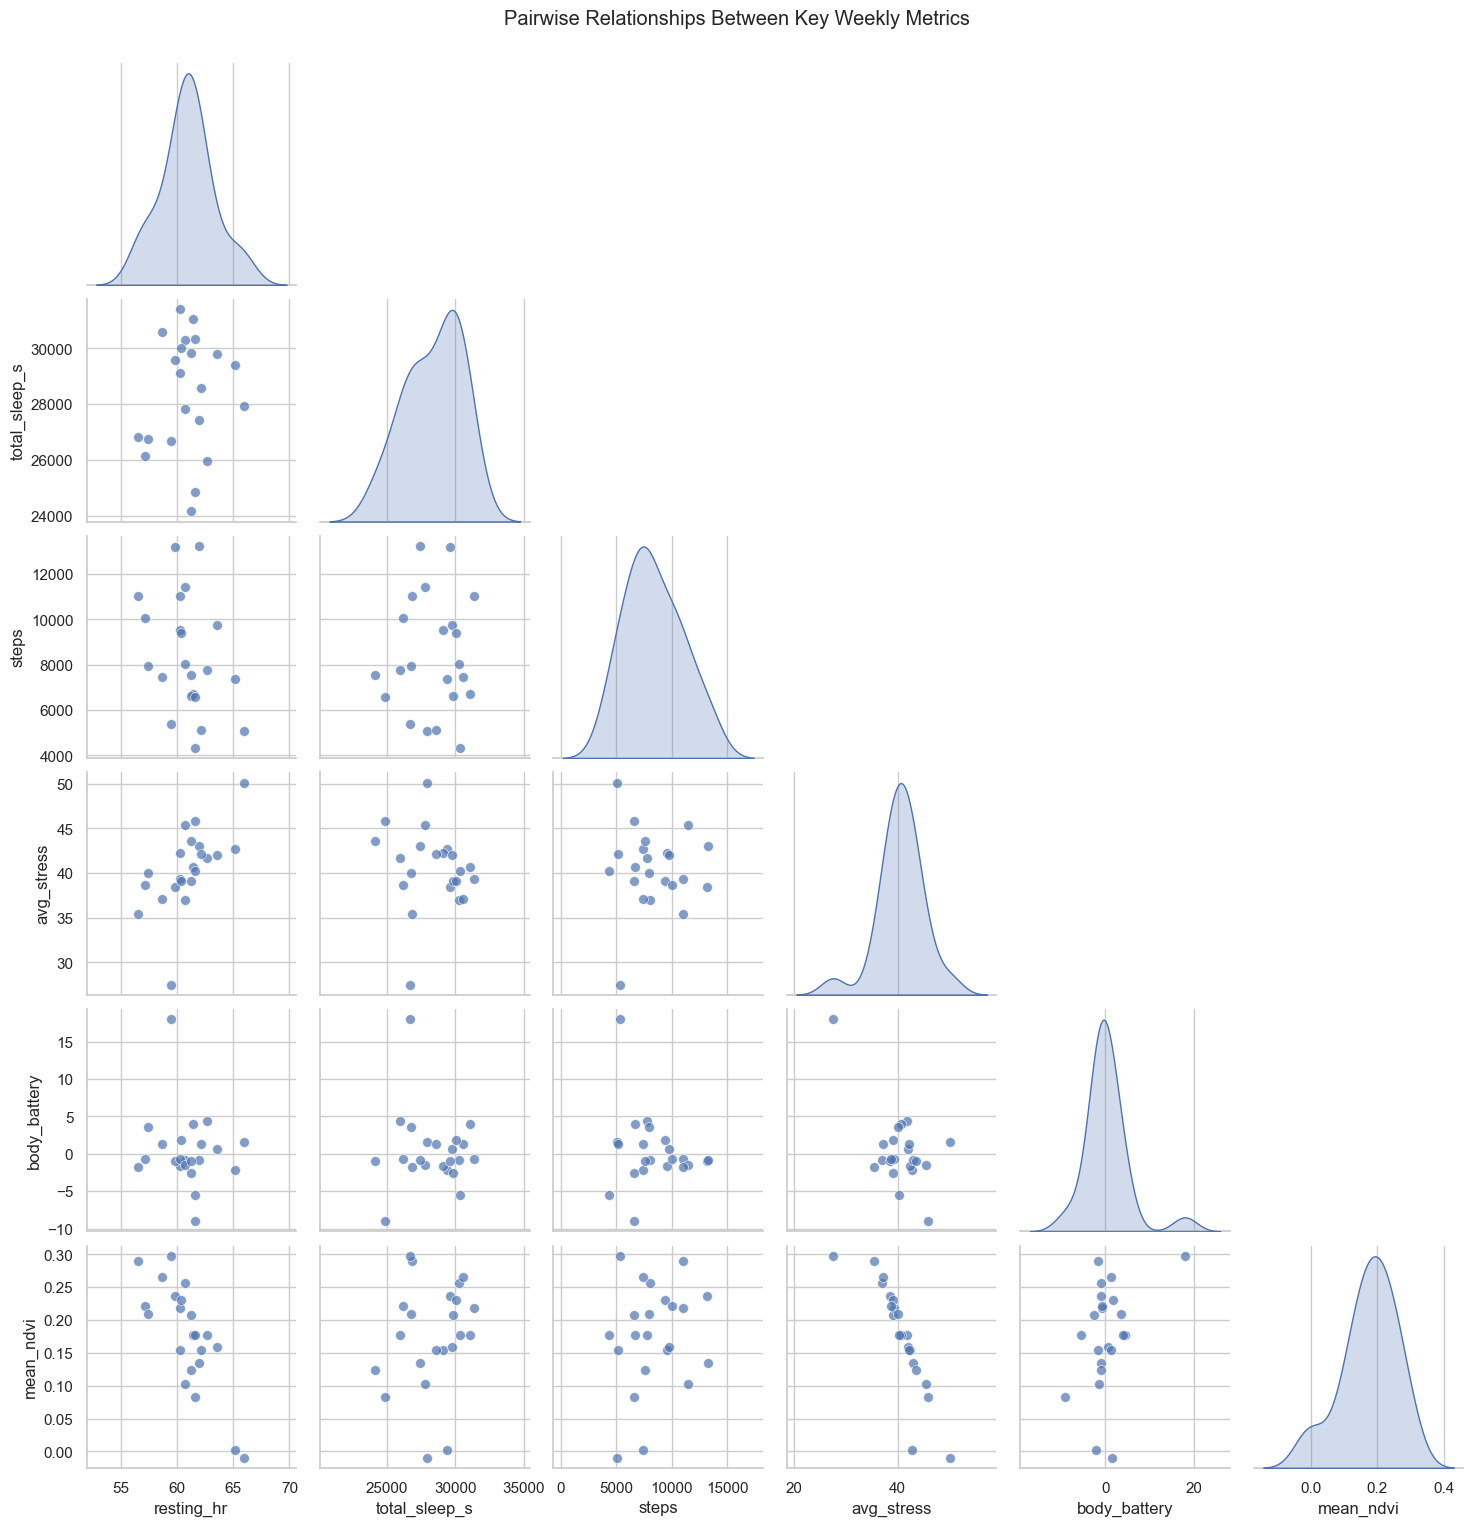

In [ ]:
# Select your focused columns
focus_cols = ['resting_hr', 'total_sleep_s', 'steps', 'avg_stress', 'body_battery', 'mean_ndvi']
subset_df = weekly_df[focus_cols].dropna()  # Drop rows with NaNs in these columns

# Create the pairplot
sns.pairplot(subset_df, corner=True, diag_kind='kde', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle("Pairwise Relationships Between Key Weekly Metrics", y=1.02)
plt.show()


# run ab testing

Group counts:
group
Spring    14
Summer     8
Name: count, dtype: int64

A/B Test results comparing 'Spring' and 'Summer' on avg_stress:
Mean Spring: 41.374 (14 samples)
Mean Summer: 39.048 (8 samples)
t-statistic: 1.056
p-value: 0.3156

Summary statistics by group:


,body_charged_mean,body_charged_std,body_drained_mean,body_drained_std,resting_hr_mean,resting_hr_std,total_sleep_s_mean,total_sleep_s_std,deep_sleep_s_mean,deep_sleep_s_std,...,light_hleep_h_mean,light_hleep_h_std,rem_hleep_h_mean,rem_hleep_h_std,awake_h_mean,awake_h_std,body_battery_mean,body_battery_std,mean_ndvi_mean,mean_ndvi_std
group,,,,,,,,,,,,,,,,,,,,,
Spring,50.802721,6.941530,51.130952,6.883640,61.736395,2.031036,29320.926871,1533.271701,4176.489796,612.676301,...,5.496207,0.329733,1.489422,0.258480,0.283475,0.213098,-0.328231,2.586986,0.161367,0.083491
Summer,59.690476,10.279697,58.154762,13.308012,59.497024,2.190308,26749.660714,1883.221766,4363.392857,676.756946,...,4.806151,0.569217,1.412401,0.131502,0.218552,0.216302,1.535714,7.638612,0.201245,0.076158



Correlations with avg_stress:
mean_ndvi       -0.866135
body_battery    -0.581186
body_charged    -0.478272
rem_sleep_s     -0.331851
rem_hleep_h     -0.331851
deep_hleep_h    -0.317549
deep_sleep_s    -0.317549
body_drained    -0.151335
total_hleep_h   -0.146056
total_sleep_s   -0.146056
steps           -0.023633
light_sleep_s    0.083580
light_hleep_h    0.083580
awake_h          0.213072
awake_s          0.213072
max_stress       0.552596
resting_hr       0.615557
avg_stress       1.000000
Name: avg_stress, dtype: float64


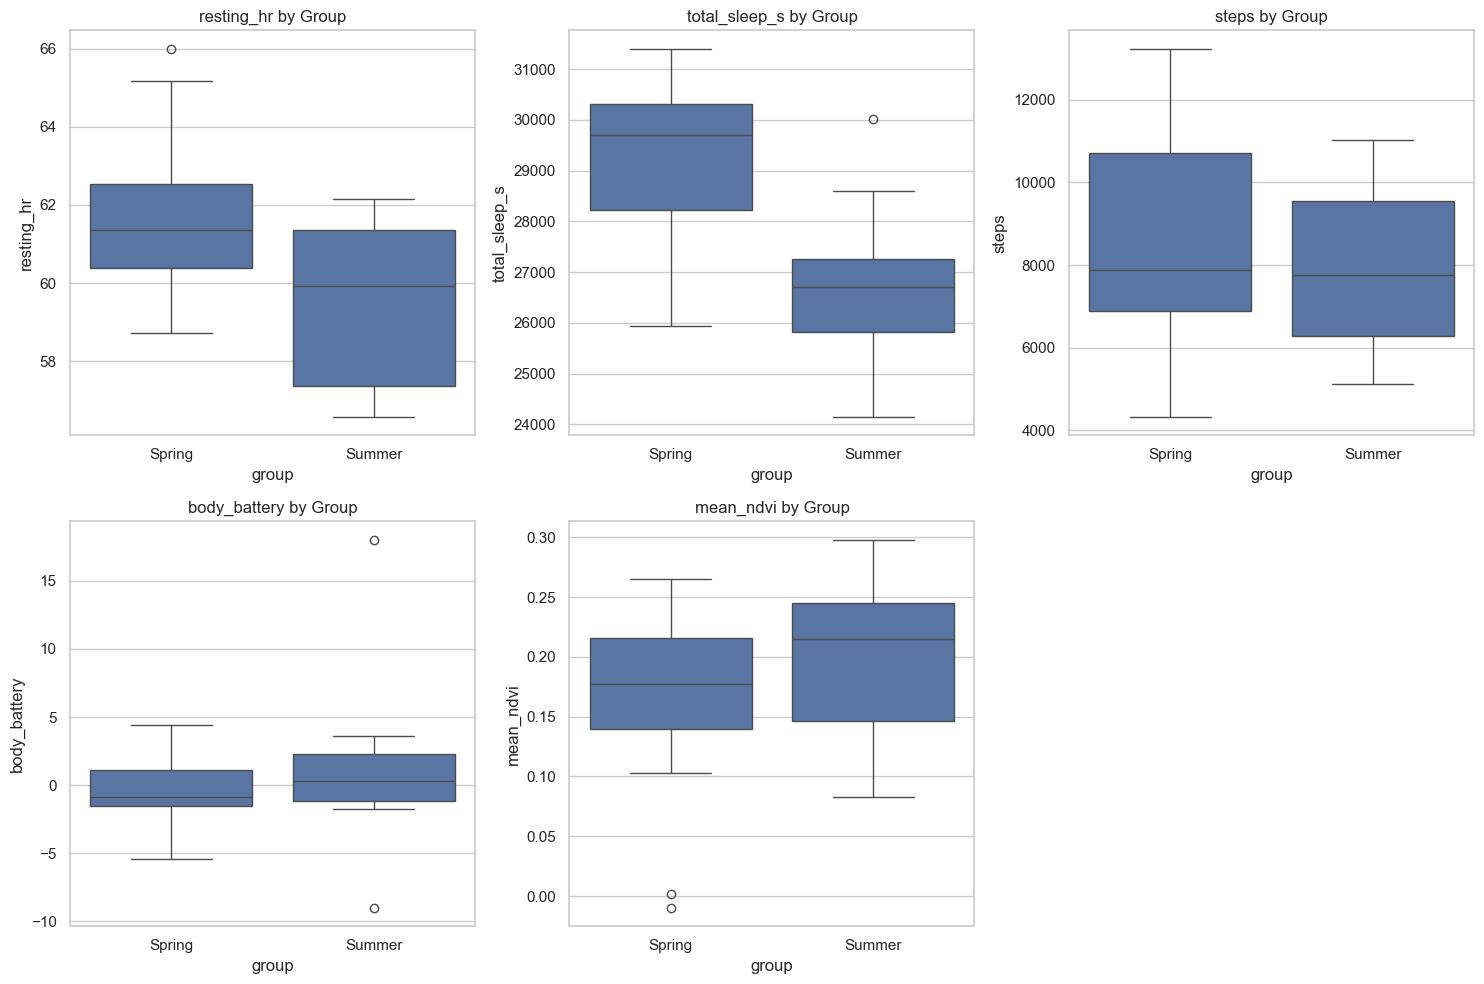

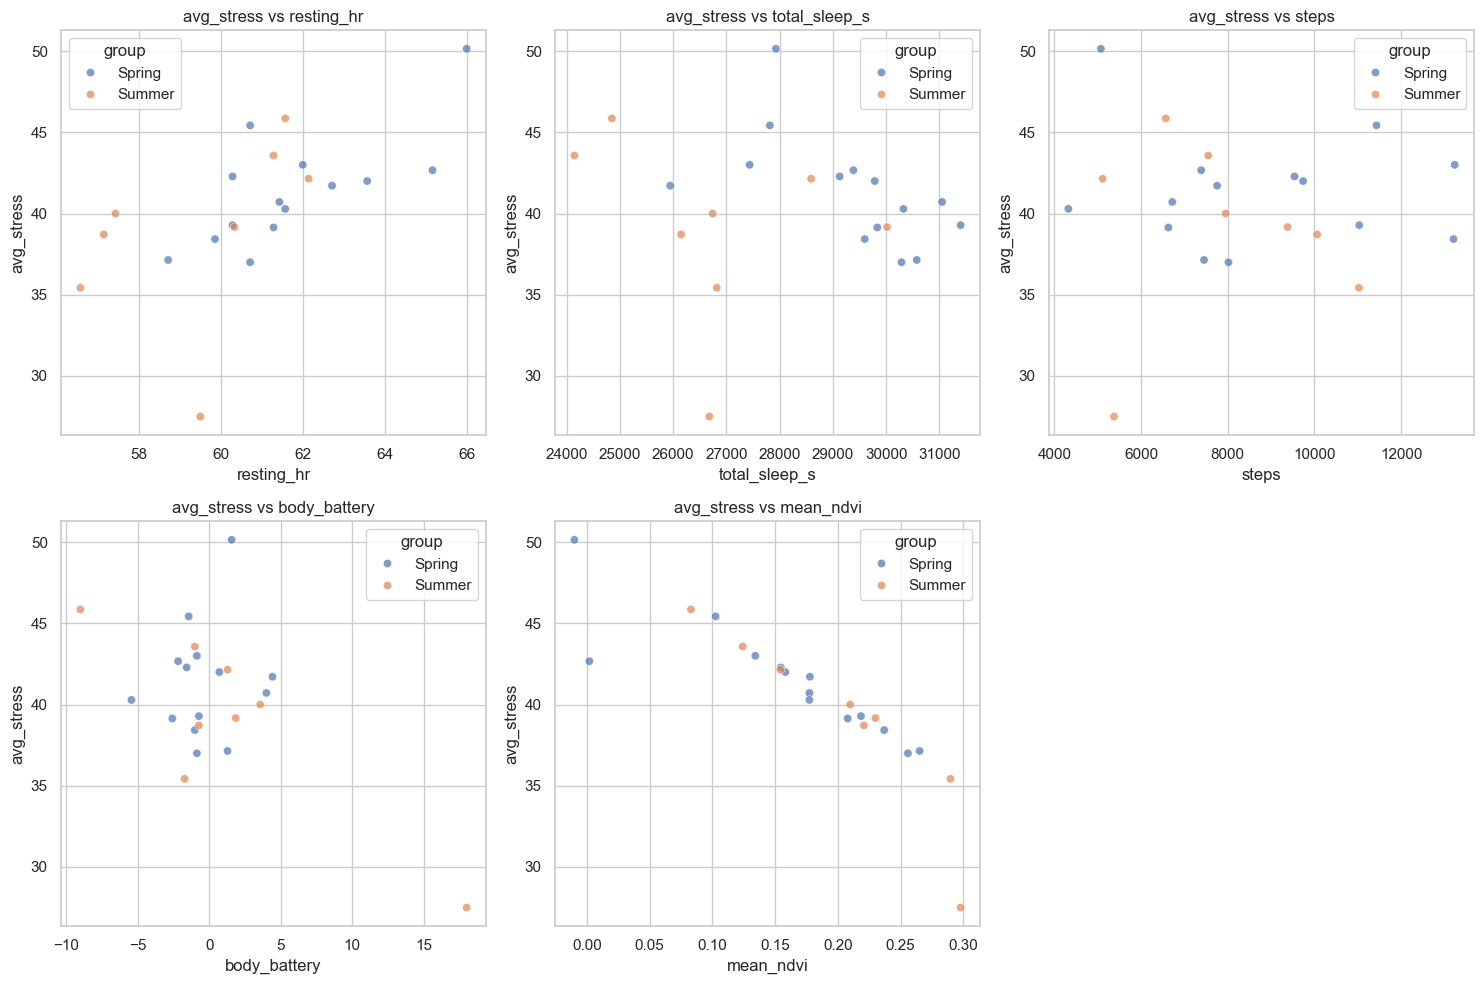

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Make sure 'date' is datetime type
weekly_df['date'] = pd.to_datetime(weekly_df['date'])

# 2. Assign season groups based on date
spring_start = pd.to_datetime("2025-03-02")
spring_end = pd.to_datetime("2025-06-01")

def assign_season_group(date):
    if spring_start <= date <= spring_end:
        return 'Spring'
    else:
        return 'Summer'

weekly_df['group'] = weekly_df['date'].apply(assign_season_group)
print("Group counts:")
print(weekly_df['group'].value_counts())

# 3. Define function to perform A/B test on a metric between groups
def perform_ab_test(df, group_col, metric_col):
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("Exactly two groups are required")
    group_a, group_b = groups

    data_a = df[df[group_col] == group_a][metric_col].dropna()
    data_b = df[df[group_col] == group_b][metric_col].dropna()

    mean_a = data_a.mean()
    mean_b = data_b.mean()
    n_a = len(data_a)
    n_b = len(data_b)

    t_stat, p_val = stats.ttest_ind(data_a, data_b, equal_var=False)

    return {
        'group_a': group_a,
        'group_b': group_b,
        'mean_a': mean_a,
        'mean_b': mean_b,
        'n_a': n_a,
        'n_b': n_b,
        't_statistic': t_stat,
        'p_value': p_val
    }

# 4. Run A/B test on avg_stress
results = perform_ab_test(weekly_df, 'group', 'avg_stress')
print(f"\nA/B Test results comparing '{results['group_a']}' and '{results['group_b']}' on avg_stress:")
print(f"Mean {results['group_a']}: {results['mean_a']:.3f} ({results['n_a']} samples)")
print(f"Mean {results['group_b']}: {results['mean_b']:.3f} ({results['n_b']} samples)")
print(f"t-statistic: {results['t_statistic']:.3f}")
print(f"p-value: {results['p_value']:.4f}")

# 5. Summary stats of numeric columns by group
numeric_cols = weekly_df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'group']

group_summary = weekly_df.groupby('group')[numeric_cols].agg(['mean', 'std'])
group_summary.columns = ['_'.join(col).strip() for col in group_summary.columns.values]
print("\nSummary statistics by group:")
display(group_summary)

# 6. Correlation of numeric variables with avg_stress
corrs = weekly_df[numeric_cols].corr()['avg_stress'].sort_values()
print("\nCorrelations with avg_stress:")
print(corrs)

# 7. Visualization: Boxplots by group
variables_to_plot = ['resting_hr', 'total_sleep_s', 'steps', 'body_battery', 'mean_ndvi']

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='group', y=var, data=weekly_df)
    plt.title(f'{var} by Group')
plt.tight_layout()
plt.show()

# 8. Visualization: Scatterplots avg_stress vs variables colored by group
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=var, y='avg_stress', hue='group', data=weekly_df, alpha=0.7)
    plt.title(f'avg_stress vs {var}')
plt.tight_layout()
plt.show()


| Metric                    | Spring (Mean ± SD) | Summer (Mean ± SD) | Interpretation                                                                        |
| ------------------------- | ------------------ | ------------------ | ------------------------------------------------------------------------------------- |
| **Body Charged**          | 50.80 ± 6.94       | 59.69 ± 10.28      | Higher body charge in Summer indicates more energy accumulation compared to Spring.   |
| **Body Drained**          | 51.13 ± 6.88       | 58.15 ± 13.31      | Body drained values are also higher in Summer, suggesting greater energy expenditure. |
| **Resting Heart Rate**    | 61.74 ± 2.03       | 59.50 ± 2.19       | Slightly higher resting heart rate in Spring.                                         |
| **Total Sleep (seconds)** | 29,321 ± 1,533     | 26,750 ± 1,883     | Spring group sleeps about 2,500 seconds (\~42 minutes) longer on average.             |
| **Deep Sleep (seconds)**  | 4,176 ± 613        | 4,363 ± 677        | Deep sleep slightly higher in Summer, but close.                                      |
| **REM Sleep (hours)**     | 1.49 ± 0.26        | 1.41 ± 0.13        | REM sleep duration marginally higher in Spring.                                       |
| **Awake (hours)**         | 0.28 ± 0.21        | 0.22 ± 0.22        | Awake time slightly higher in Spring.                                                 |
| **Body Battery**          | -0.33 ± 2.59       | 1.54 ± 7.64        | Body battery mean is higher in Summer, with greater variability.                      |
| **Mean NDVI**             | 0.16 ± 0.08        | 0.20 ± 0.08        | NDVI values (proxy for vegetation index) slightly higher in Summer.                   |


| Variable               | Correlation with `avg_stress` | Interpretation                                                                     |
| ---------------------- | ----------------------------- | ---------------------------------------------------------------------------------- |
| **Mean NDVI**          | -0.87                         | Strong negative correlation: higher vegetation index associates with lower stress. |
| **Body Battery**       | -0.58                         | Higher body battery links to lower stress.                                         |
| **Body Charged**       | -0.48                         | More energy charged associates with reduced stress.                                |
| **REM Sleep**          | -0.33                         | More REM sleep correlates with lower stress.                                       |
| **Deep Sleep**         | -0.32                         | Deep sleep also relates inversely with stress.                                     |
| **Body Drained**       | -0.15                         | Weak negative correlation with stress.                                             |
| **Total Sleep**        | -0.15                         | Slightly less sleep associates with higher stress.                                 |
| **Steps**              | -0.02                         | No meaningful correlation.                                                         |
| **Light Sleep**        | +0.08                         | Slight positive correlation (more light sleep, more stress).                       |
| **Awake Time**         | +0.21                         | More awake time during sleep associates with higher stress.                        |
| **Max Stress**         | +0.55                         | Max stress positively correlates with average stress, as expected.                 |
| **Resting Heart Rate** | +0.62                         | Higher resting heart rate strongly associates with higher stress.                  |


# regression analysis

In [ ]:

# Select features for regression
features = ['mean_ndvi', 'body_battery', 'resting_hr', 'total_sleep_s', 'steps']
X = weekly_df[features]
y = weekly_df['avg_stress']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             avg_stress   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     15.93
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           1.02e-05
Time:                        11:41:59   Log-Likelihood:                -43.644
No. Observations:                  22   AIC:                             99.29
Df Residuals:                      16   BIC:                             105.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            47.3194     23.738      1.993

Key Takeaways

Mean NDVI (vegetation index) has the strongest and most statistically significant negative impact on stress. This supports the idea that greener environments reduce stress.
Body Battery also significantly predicts lower stress levels, confirming its usefulness as a biomarker.
Resting heart rate, total sleep, and steps do not significantly explain stress variance once NDVI and body battery are accounted for.
The model explains a very large proportion of stress variability, indicating these two factors are very important.

In [ ]:
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator
import subprocess
import os

# ------------------- Configuration -------------------
PROJECT_DIR = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal"
RAW_DIR = os.path.join(PROJECT_DIR, "data/raw")

GARMIN_SCRIPTS = {
    "fetch_raw": os.path.join(PROJECT_DIR, "scripts/parse_garmin.py"),
    "load_bq": os.path.join(PROJECT_DIR, "scripts/load_to_bigquery.py"),
}

DEFAULT_ARGS = {
    "owner": "tolga",
    "depends_on_past": False,
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
}

# ------------------- DAG Definition -------------------
with DAG(
    "garmin_to_bigquery",
    default_args=DEFAULT_ARGS,
    description="Fetch Garmin data and load to BigQuery",
    schedule_interval="0 22 * * 0",  # Every Sunday at 22:00
    start_date=datetime(2025, 10, 12),  # adjust to your first run
    catchup=False,
    tags=["garmin", "bigquery"],
) as dag:

    def run_script(script_path):
        """Run a Python script in a subprocess."""
        result = subprocess.run(
            ["python3", script_path],
            capture_output=True,
            text=True
        )
        if result.returncode != 0:
            raise RuntimeError(f"Script failed: {script_path}\n{result.stderr}")
        print(result.stdout)

    # ------------------- Tasks -------------------
    fetch_raw_task = PythonOperator(
        task_id="fetch_raw_data",
        python_callable=run_script,
        op_kwargs={"script_path": GARMIN_SCRIPTS["fetch_raw"]},
    )

    load_bq_task = PythonOperator(
        task_id="load_to_bigquery",
        python_callable=run_script,
        op_kwargs={"script_path": GARMIN_SCRIPTS["load_bq"]},
    )

    # ------------------- Task Order -------------------
    fetch_raw_task >> load_bq_task


Found 1134 JSON files in /Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw

--- File 1: body_battery_2025-09-22.json ---
Type: list | Length: 1
Sample keys from first element: ['date', 'charged', 'drained', 'startTimestampGMT', 'endTimestampGMT', 'startTimestampLocal', 'endTimestampLocal', 'bodyBatteryValuesArray', 'bodyBatteryValueDescriptorDTOList', 'bodyBatteryDynamicFeedbackEvent', 'bodyBatteryActivityEvent']
--------------------------------------------------
--- File 2: heart_rate_2025-04-17.json ---
Type: dict | Top-level keys: ['userProfilePK', 'calendarDate', 'startTimestampGMT', 'endTimestampGMT', 'startTimestampLocal', 'endTimestampLocal', 'maxHeartRate', 'minHeartRate', 'restingHeartRate', 'lastSevenDaysAvgRestingHeartRate', 'heartRateValueDescriptors', 'heartRateValues']
--------------------------------------------------
--- File 3: body_battery_2025-05-01.json ---
Type: list | Length: 1
Sample keys from first element: ['date', 'charged', 'drained', 'startTimesta